# Model Inspection

A one stop shop for inspecting the full data pipeline and model inference results.

In [1]:
import numpy as np
import sys
import pickle
import os
import re
import json
import h5py as h5
import matplotlib.pyplot as plt
from skimage.io import imread
import path
from pathlib import Path

In [2]:
import pyvista as pv
from itkwidgets import view

In [3]:
import torch

from pytorch3d.ops import cubify

from pytorch3d.io import save_ply, save_obj, load_objs_as_meshes, load_obj, load_ply

from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardPhongShader,
    TexturesUV,
    Textures,
    TexturesVertex
)

from pytorch3d.datasets.r2n2.utils import (
    BlenderCamera,
    align_bbox,
    compute_extrinsic_matrix,
    read_binvox_coords,
    voxelize,
)

In [4]:
# Setup Torch Device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
device

device(type='cuda', index=0)

Set project directory here to find meta-parameter files:

In [6]:
git_project_directory = '/home/ubuntu/Insight/DeepDream3D/'

## Parse Directories

In [7]:
def regex_directory_parser(directory_path, regex):
    files = os.listdir(directory_path)
    files_list = []
    for filename in files:
        if regex.match(filename) is not None:
            files_list.append(filename)
            
    return files_list

In [8]:
data_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
data_files = os.listdir(data_path)
data_files;

In [9]:
reg_data = re.compile('\w*.hdf5')
datafiles_list = regex_directory_parser(data_path, reg_data)
print(datafiles_list)

['all_vox256_img_test.hdf5', 'all_vox256_img_train.hdf5']


In [10]:
output_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
output_files = os.listdir(output_path);
output_files;

In [11]:
reg_vox = re.compile('\w*_vox.ply')
output_vox_file_list = regex_directory_parser(output_path, reg_vox)
print(output_vox_file_list)

[]


Inspect pre-computed hdf5 data file sturcture.

In [12]:
def recursive_hdf5(entity,  numtab = 0):
    if isinstance(entity, h5.Group):
        for key in entity.keys():
            print('\t'*numtab + key)
            new_tab_level = numtab + 1
            recursive_hdf5(entity[key], new_tab_level)
    elif isinstance(entity, h5.Dataset):
        print('\t shape: ' + str(entity.shape))
    
    return

In [13]:
data_file = h5.File(data_path + datafiles_list[0], 'r')

In [14]:
recursive_hdf5(data_file, 0)

pixels
	 shape: (8762, 24, 137, 137)
points_16
	 shape: (8762, 4096, 3)
points_32
	 shape: (8762, 4096, 3)
points_64
	 shape: (8762, 16384, 3)
values_16
	 shape: (8762, 4096, 1)
values_32
	 shape: (8762, 4096, 1)
values_64
	 shape: (8762, 16384, 1)
voxels
	 shape: (8762, 64, 64, 64, 1)


Inspect pre-computed latent vector file

In [15]:
checkpoint_dir = '/data/IM-NET-pytorch/checkpoint/'
model_dir = 'all_vox256_img_ae_64/'
latent_z_filename = 'all_vox256_img_train_z.hdf5'
latent_h5_file = h5.File(checkpoint_dir+model_dir+latent_z_filename, 'r')

In [16]:
recursive_hdf5(latent_h5_file, 0)

zs
	 shape: (35019, 256)


In [17]:
print(latent_h5_file['zs'].attrs.keys())

<KeysViewHDF5 []>


## Inspect Model Inputs

Choose a training model to inspect

In [159]:
num_models = data_file['pixels'].shape[0]
num_models

8762

In [184]:
input_num = np.random.randint(low=0, high=num_models)
input_num = 3800

### Images

Look at the 24 input renderings..

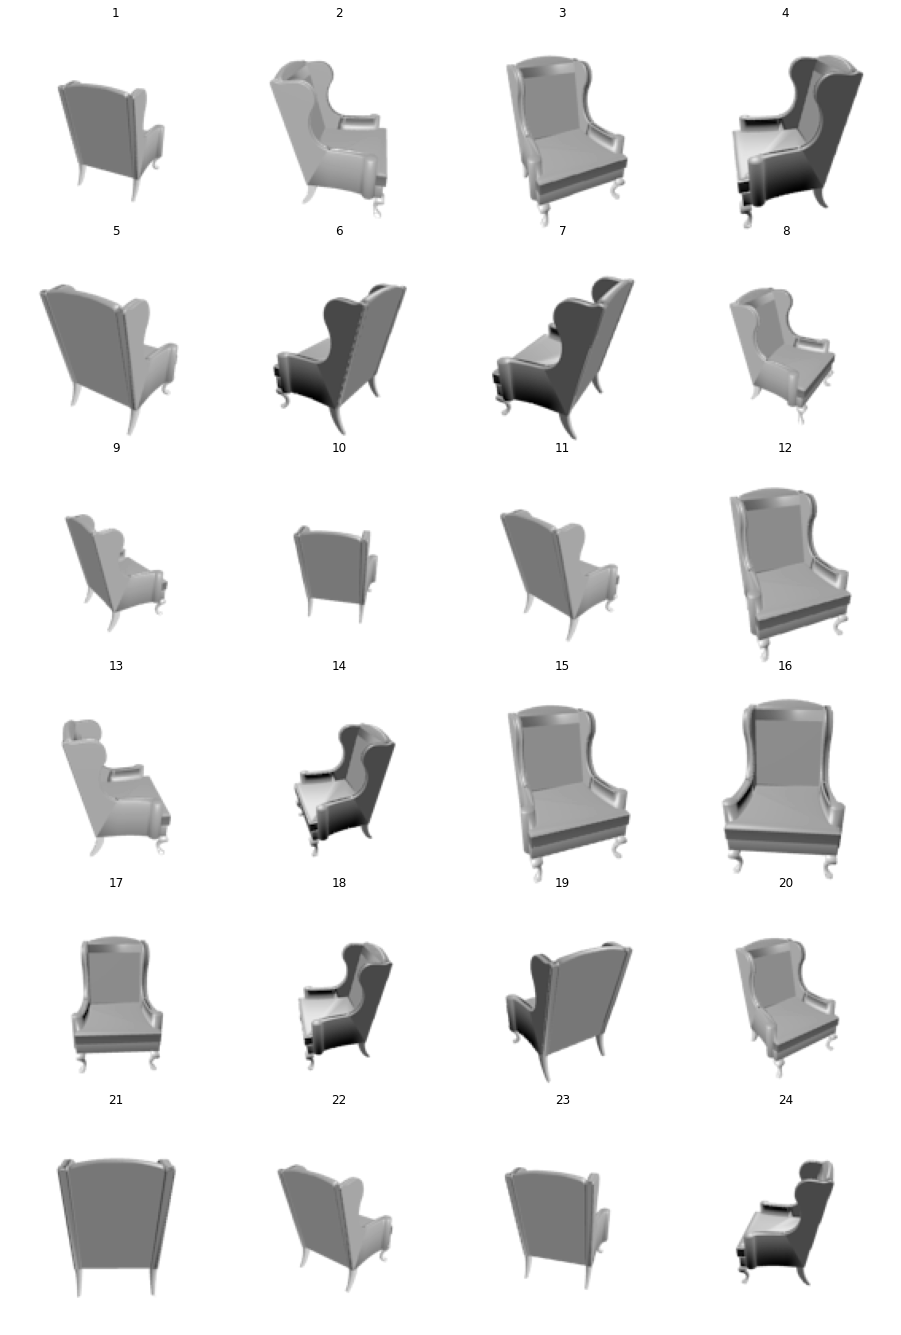

In [185]:
fig, axs = plt.subplots(nrows=6, 
                        ncols=4, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(4*4,6*4),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
images = data_file['pixels'][input_num][...]
for ax, im in zip(axs.flatten(), range(24)):
    ax.set_title(im+1)
    ax.imshow(images[im,:,:], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    

(-0.5, 136.5, 136.5, -0.5)

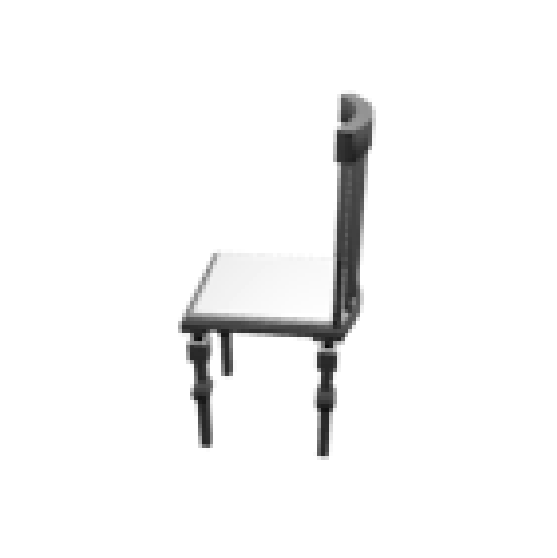

In [183]:
plt.figure(figsize=(10,10))
plt.imshow(images[23,:,:], cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In [18]:
shapenet_cam_params_file = git_project_directory + 'data/metadata/rendering_metadata.json' 
with open(shapenet_cam_params_file) as f:
  shapenet_cam_params = json.load(f)

In [19]:
def get_camera(view_num):
    param_num = view_num
    R, T = look_at_view_transform(
        dist=shapenet_cam_params["distance"][param_num]*3, 
        elev=shapenet_cam_params["elevation"][param_num], 
        azim=shapenet_cam_params["azimuth"][param_num]) 
    cameras = FoVPerspectiveCameras(device=device, 
                                    R=R, 
                                    T=T,
                                    fov=shapenet_cam_params["field_of_view"][param_num]
                                   )

    raster_settings = RasterizationSettings(
        image_size=512, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )

    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=HardPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )
    
    return renderer

In [21]:
interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/DeepDream_300_1600_layer_3/'
files = os.listdir(interpolation_dir)
print(files)
verts = []
faces = []
verts_rgb = []
titles = []
for file in files:
    if file.split('.')[1] == 'ply':
        titles.append(file.split('/')[-1])
        vert, face = load_ply(interpolation_dir + file)
        verts.append(vert.to(device))
        faces.append(face.to(device))
        verts_rgb.append(torch.ones_like(vert).to(device))
        break

textures = Textures(verts_rgb=verts_rgb)
interpol_mesh = Meshes(verts, faces, textures)

['0_vox.ply', '1_vox.ply', '2_vox.ply', '3_vox.ply', '4_vox.ply']


In [22]:
images = []
for view_num in range(24):
    renderer = get_camera(view_num)
    image_render = renderer(interpol_mesh)
    images.append(image_render.cpu().numpy())

In [23]:
images[2].shape

(1, 512, 512, 4)

4
6


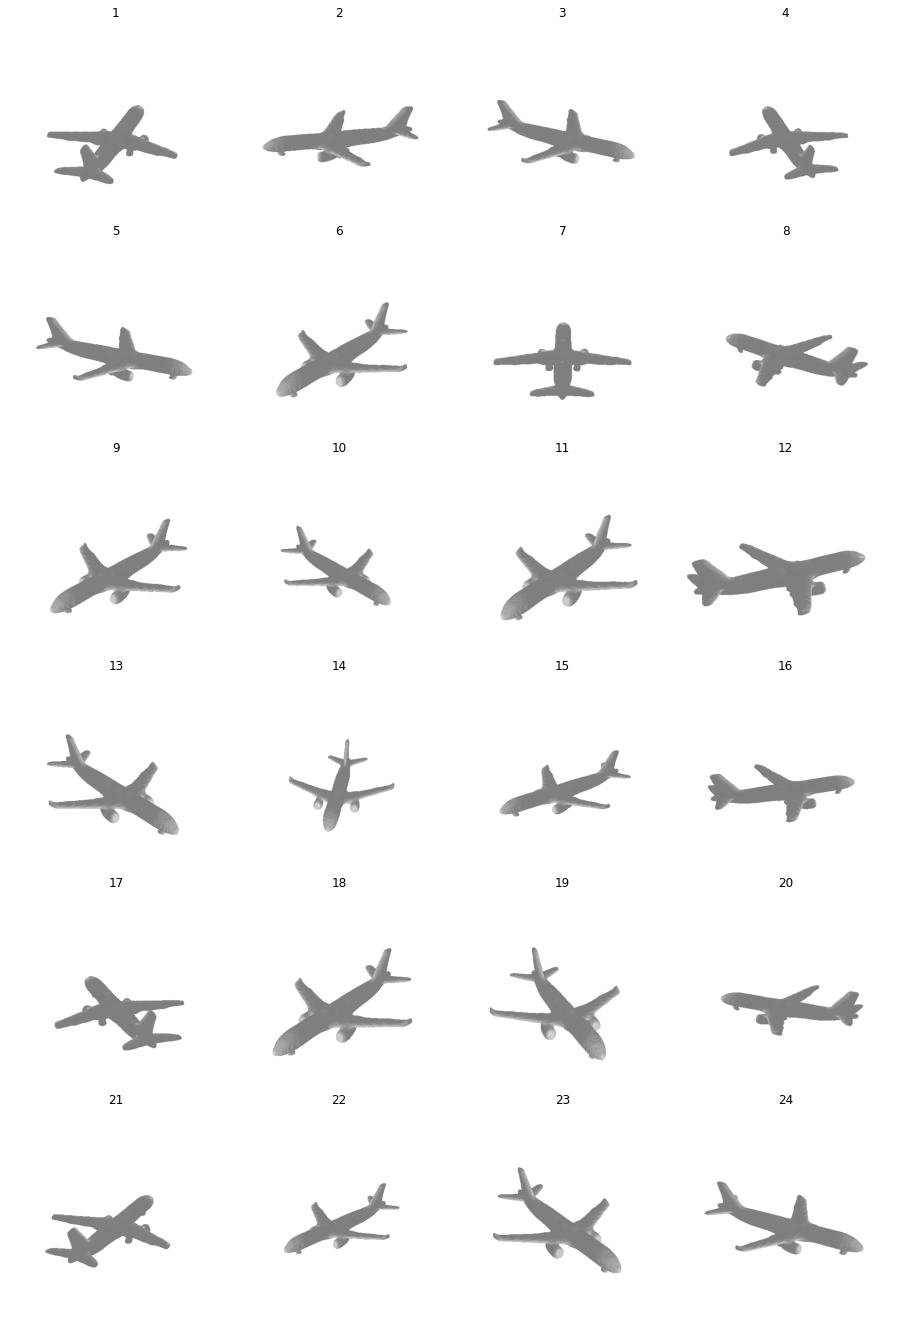

In [24]:
num_images = len(images)
rows = 6 
cols = -int(-num_images // rows)
print(cols)
print(rows)

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*4,rows*4),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), range(num_images)):
    ax.set_title(im+1)
    ax.imshow(images[im][0,:,:,:3])
    ax.axis('off')

(-0.5, 511.5, 511.5, -0.5)

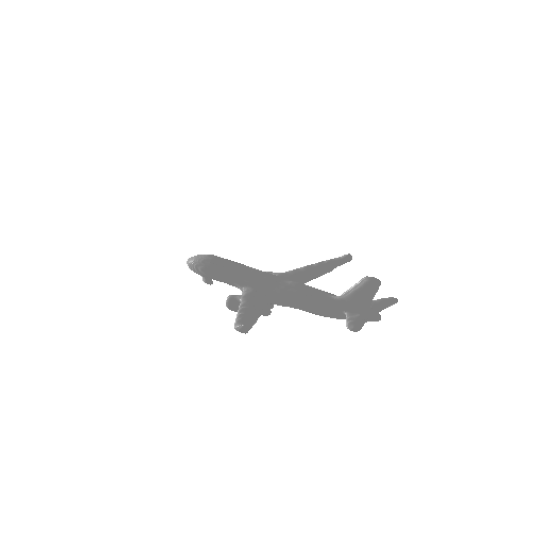

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(images[7][0,:,:,:3], cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In [78]:
METADATA_DIR = Path().resolve().parents[0]
MAX_CAMERA_DISTANCE = 1.75  # Constant from R2N2.
# Intrinsic matrix extracted from Blender. Taken from meshrcnn codebase:
# https://github.com/facebookresearch/meshrcnn/blob/master/shapenet/utils/coords.py
BLENDER_INTRINSIC = torch.tensor(
    [
        [2.1875, 0.0, 0.0, 0.0],
        [0.0, 2.1875, 0.0, 0.0],
        [0.0, 0.0, -1.002002, -0.2002002],
        [0.0, 0.0, -1.0, 0.0],
    ]
)


class ShapeNetRendering:
    '''
    This is a class finds the rendering parameters for the shapenet model in question and reconstructs the rendering
    pipeline as done in PyTorch3D from facebook research.

    Most of this code has been adapted from PyTorch3D R2N2 dataset architecture:
    https://pytorch3d.readthedocs.io/en/latest/modules/datasets.html

    Subclassing the architecture was deemed more difficult than re-factoring only what functions were necessary.

    '''

    def __init__(self,
                 model_nums: list,
                 R2N2_dir: str,
                 splitfile: str = 'data/metadata/all_vox256_img_test.txt',
                 model_views: list = None,
                 views_rel_path: str = "ShapeNetRendering"
                 ):
        '''
        :param model_num: model number to find.
        :param splitfile: File containing the sysnet ids for each entry in the hdf5 datafile
        :param R2N2_dir: directory where shapenet v2 renderings are stored
        :param model_view: view number to render
        :param views_rel_path: the relative path from the R2N2 directory for views
        '''

        # self.model_num = model_nums
        self.r2n2_dir = R2N2_dir
        self.splitfile = splitfile
        # self.model_views = model_views
        self.views_rel_path = views_rel_path

        self.models = []
        for model_num, model_view in zip(model_nums, model_views):
            self.models.append(self.get_model(model_num=model_num, model_views=model_view))

    def get_model(self, model_num, model_views):
        model = {}

        # get model based on id number in splitfile
        with open(os.path.join(METADATA_DIR, self.splitfile), "r") as f:
            synset_lines = f.readlines()
            synset_id, model_id = synset_lines[model_num].split('/')
            model["synset_id"] = synset_id
            model["model_id"] = model_id.rstrip()

        print(model)
        
        Rs, Ts, voxel_RTs = [], [], []

        rendering_path = os.path.join(
            self.r2n2_dir,
            self.views_rel_path,
            model["synset_id"],
            model["model_id"],
            "rendering",
        )

        # Read metadata file to obtain params for calibration matrices.
        with open(os.path.join(rendering_path, "rendering_metadata.txt"), "r") as f:
            metadata_lines = f.readlines()
        for i in model_views:
            # Get camera calibration.
            azim, elev, yaw, dist_ratio, fov = [
                float(v) for v in metadata_lines[i].strip().split(" ")
            ]
            dist = dist_ratio * MAX_CAMERA_DISTANCE
            # Extrinsic matrix before transformation to PyTorch3D world space.
            RT = compute_extrinsic_matrix(azim, elev, dist)
            R, T = self._compute_camera_calibration(RT)
            Rs.append(R)
            Ts.append(T)
            voxel_RTs.append(RT)

        # Intrinsic matrix extracted from the Blender with slight modification to work with
        # PyTorch3D world space. Taken from meshrcnn codebase:
        # https://github.com/facebookresearch/meshrcnn/blob/master/shapenet/utils/coords.py
        K = torch.tensor(
            [
                [2.1875, 0.0, 0.0, 0.0],
                [0.0, 2.1875, 0.0, 0.0],
                [0.0, 0.0, -1.002002, -0.2002002],
                [0.0, 0.0, 1.0, 0.0],
            ]
        )

        model["R"] = torch.stack(Rs)
        model["T"] = torch.stack(Ts)
        model["K"] = K.expand(len(model_views), 4, 4)

        return model

    def _compute_camera_calibration(self, RT):
        """
        Helper function for calculating rotation and translation matrices from ShapeNet
        to camera transformation and ShapeNet to PyTorch3D transformation.

        Args:
            RT: Extrinsic matrix that performs ShapeNet world view to camera view
                transformation.

        Returns:
            R: Rotation matrix of shape (3, 3).
            T: Translation matrix of shape (3).
        """
        # Transform the mesh vertices from shapenet world to pytorch3d world.
        shapenet_to_pytorch3d = torch.tensor(
            [
                [-1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, -1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            dtype=torch.float32,
        )
        RT = torch.transpose(RT, 0, 1).mm(shapenet_to_pytorch3d)  # (4, 4)
        # Extract rotation and translation matrices from RT.
        R = RT[:3, :3]
        T = RT[3, :3]
        return R, T

    def render(
            self,
            model_ids: list = None,
            meshes: Meshes = None,
            shader_type=HardPhongShader,
            device="cpu"
    ) -> torch.Tensor:
        """
        Render models with BlenderCamera by default to achieve the same orientations as the
        R2N2 renderings. Also accepts other types of cameras and any of the args that the
        render function in the ShapeNetBase class accepts.

        Args:
            model_ids: List[str] of model_ids of models intended to be rendered.
            meshes: List[Meshes] mesh with textures corresponding to model ids
            shader_type: Shader to use for rendering. Examples include HardPhongShader
            (default), SoftPhongShader etc or any other type of valid Shader class.
            device: torch.device on which the tensors should be located.
            **kwargs: Accepts any of the kwargs that the renderer supports and any of the
                args that BlenderCamera supports.

        Returns:
            Batch of rendered images of shape (N, H, W, 3).
        """

        # unpack values for models
        r_, t_, k_ = [], [], []
        for id in model_ids:
            r_.append(self.models[id]["R"])
            t_.append(self.models[id]["T"])
            k_.append(self.models[id]["K"])

        r = torch.cat(r_)
        t = torch.cat(t_)
        k = torch.cat(k_)
        # Initialize default camera using R, T, K from kwargs or R, T, K of the specified views.
        blend_cameras = BlenderCamera(
            R=r,
            T=t,
            K=k,
            device=device,
        )
        cameras = blend_cameras

        if len(cameras) != 1 and len(cameras) % len(meshes) != 0:
            raise ValueError("Mismatch between batch dims of cameras and meshes.")
        if len(cameras) > 1:
            # When rendering R2N2 models, if more than one views are provided, broadcast
            # the meshes so that each mesh can be rendered for each of the views.
            meshes = meshes.extend(len(cameras) // len(meshes))

        print(meshes.isempty())
        print(meshes.num_verts_per_mesh())

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=2
        )
        
        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
        
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings,
            ),
            shader=shader_type(
                device=device,
                cameras=cameras,
                lights=lights,
            ),
        )
        return renderer(meshes)

In [79]:
shape_net_rendering = ShapeNetRendering(model_nums = [300],
                 R2N2_dir = '/data/shapenet',
                 splitfile = 'data/metadata/all_vox256_img_test.txt',
                 model_views = [range(24)],
                 views_rel_path = "ShapeNetRendering")

{'synset_id': '02691156', 'model_id': 'e160529ef50ae4dbb819cac660ba383c'}


In [27]:
voxels_ = data_file['voxels'][input_num][...]
np.flip(voxels_,2)
np.transpose(np.flip(voxels_,2),(2,1,0,3))
voxels_.shape

NameError: name 'input_num' is not defined

In [236]:
print(np.alltrue(np.transpose(np.transpose(voxels_,(2,1,0,3)),(2,1,0,3)) == voxels_))
print(np.alltrue(np.flip(np.flip(voxels_,2),2) == voxels_))
print(np.alltrue(np.transpose(np.flip(np.flip(np.transpose(voxels_,(2,1,0,3)), 2),2),(2,1,0,3)) == voxels_))


True
True
True


In [14]:
voxels_ = data_file['voxels'][input_num][...]
#voxels_ = np.transpose(np.flip(voxels_,2),(2,1,0,3)).copy()
#voxels_ = np.transpose(voxels_,(2,1,0,3)).copy()

voxels_ = voxels_[np.newaxis,:,:,:,0]
voxels = torch.tensor(voxels_,dtype=torch.float64, device=torch.device('cpu'))
voxel_mesh = cubify(voxels, thresh=.5, align='topleft').to(device)

verts_rgb = torch.ones_like(voxel_mesh.verts_list()[0])[None]
textures = Textures(verts_rgb=verts_rgb.to(device))
voxel_mesh.textures = textures

NameError: name 'data_file' is not defined

In [15]:
images = shape_net_rendering.render( 
            model_ids = [0],
            meshes = voxel_mesh,
            shader_type=HardPhongShader,
            device=device).to('cpu').numpy()

NameError: name 'voxel_mesh' is not defined

4
6


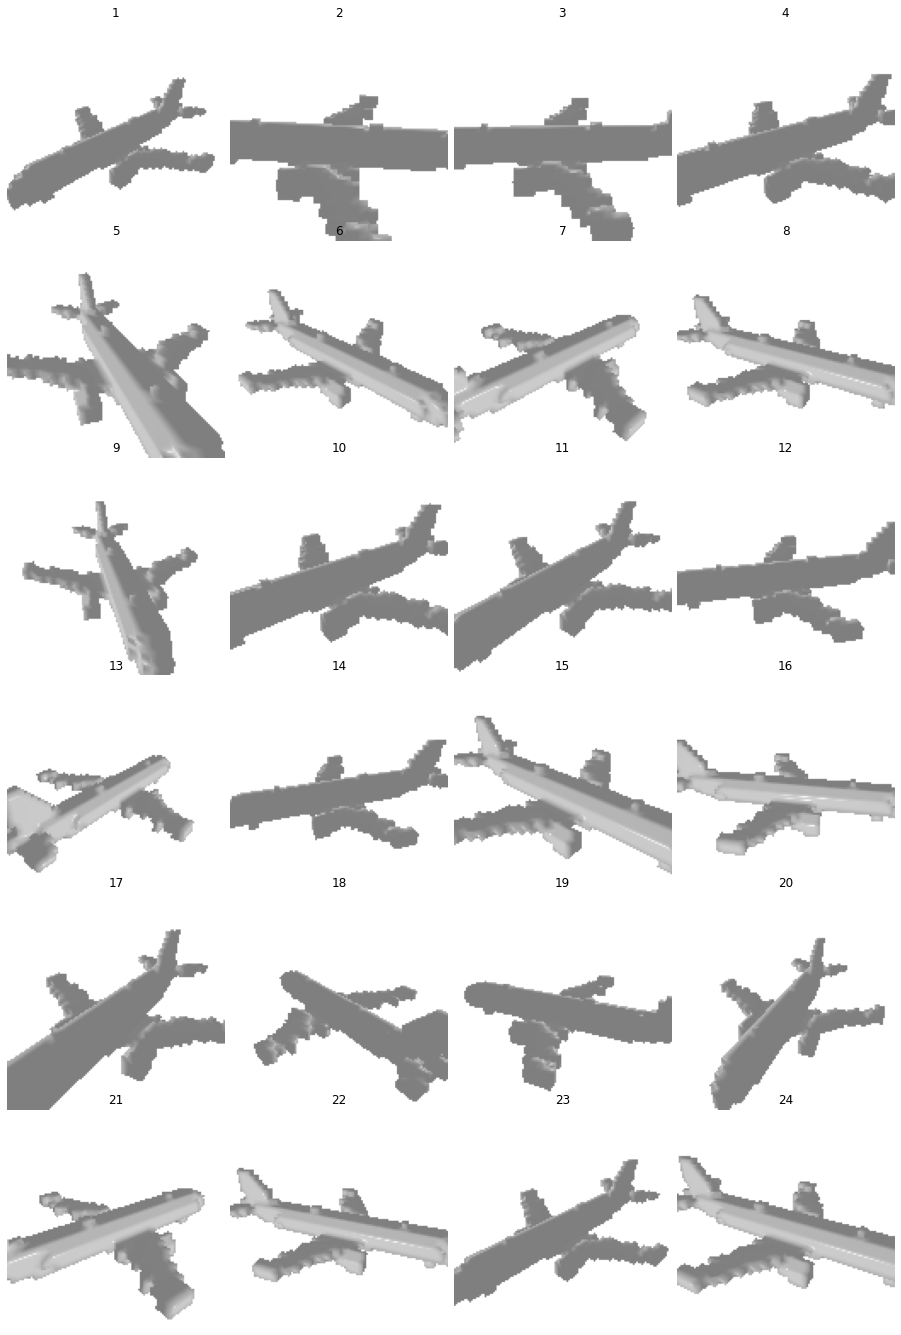

In [239]:
num_images = len(images)
rows = 6 
cols = -int(-num_images // rows)
print(cols)
print(rows)

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*4,rows*4),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), range(num_images)):
    ax.set_title(im+1)
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')

In [16]:
interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/DeepDream_SVR300_1600_layer_3/'
files = os.listdir(interpolation_dir)
print(files)
verts = []
faces = []
verts_rgb = []
titles = []
for file in files:
    if file.split('.')[1] == 'ply':
        titles.append(file.split('/')[-1])
        print(file)
        vert, face = load_ply(interpolation_dir + file)
        verts.append(vert.to(device))
        faces.append(face.to(device))
        verts_rgb.append(torch.ones_like(vert).to(device))
        break

textures = Textures(verts_rgb = verts_rgb)
interpol_mesh = Meshes(verts, faces, textures)

['base_vox.ply', 'target_vox.ply', '1_vox.ply', '2_vox.ply', '3_vox.ply', '4_vox.ply', 'deepdream_images.png', 'annealing_images.png']
base_vox.ply


In [17]:
images = shape_net_rendering.render( 
            model_ids = [0],
            meshes = interpol_mesh,
            shader_type=HardPhongShader,
            device=device).to('cpu').numpy()

tensor(False, device='cuda:0')
tensor([31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556,
        31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556, 31556,
        31556, 31556, 31556, 31556], device='cuda:0')


In [18]:
images = images / images.max()


4
6


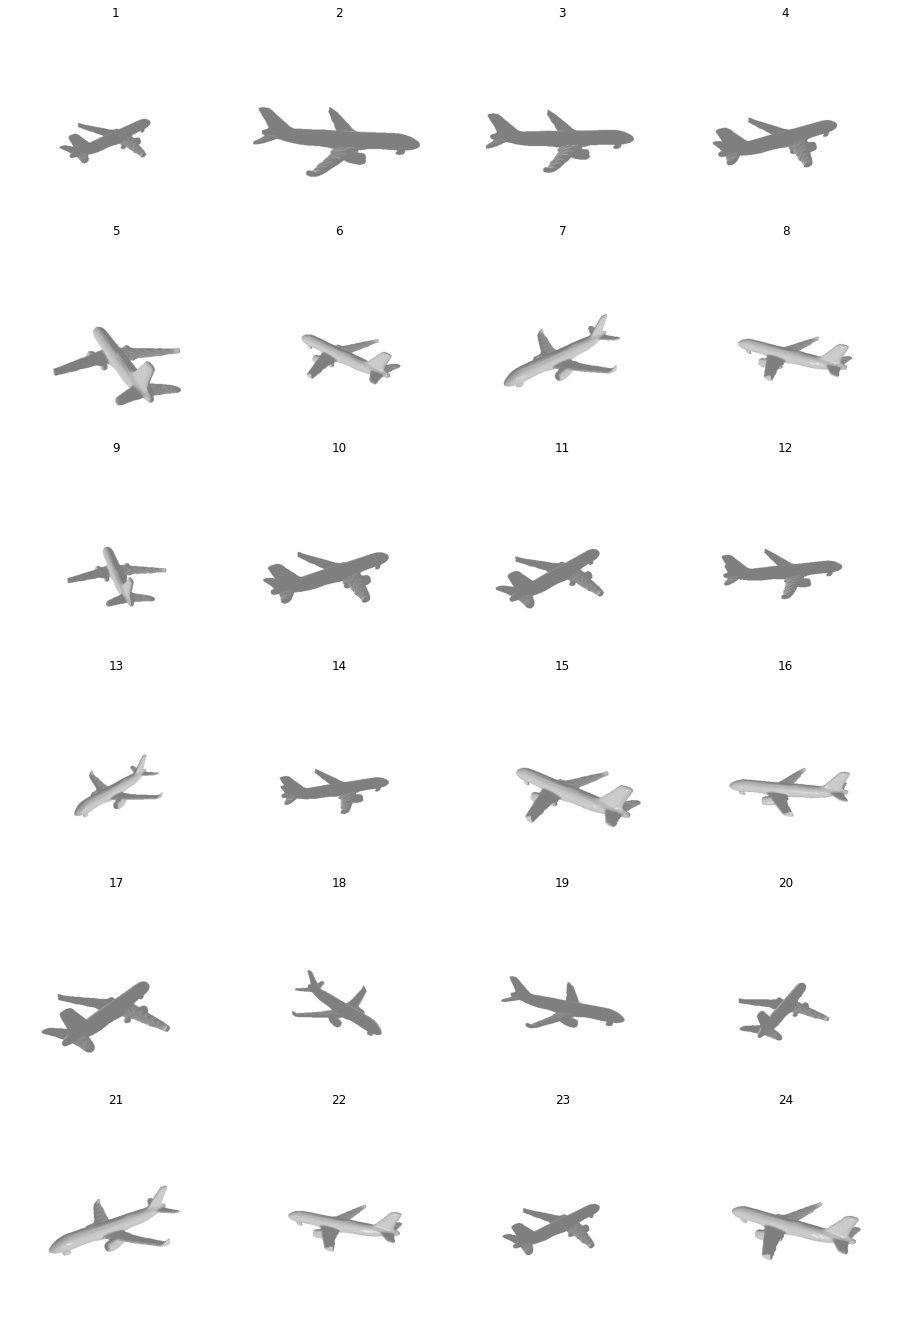

In [19]:
num_images = len(images)
rows = 6 
cols = -int(-num_images // rows)
print(cols)
print(rows)

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*4,rows*4),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), range(num_images)):
    ax.set_title(im+1)
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')

### Input Voxels

Look at the voxelized input model. Use the cubify function from PyTorch3D to convert from binvox 3D grid occupancy
to renderable mesh surface. 

In [184]:
voxels_ = data_file['voxels'][input_num][...]
voxels_ = voxels_[np.newaxis,:,:,:,0]
voxels_.shape
voxels = torch.tensor(voxels_,dtype=torch.float64, device=torch.device('cpu'))

In [185]:
voxels;

In [186]:
voxel_mesh = cubify(voxels, thresh=.5, align='topleft')

In [187]:
voxel_mesh.verts_list()[0]

tensor([[ 0.4286, -0.3016, -0.3333],
        [ 0.4286, -0.3016, -0.3016],
        [ 0.4286, -0.3016, -0.2698],
        ...,
        [ 0.2698,  0.3333, -0.0159],
        [ 0.2698,  0.3333,  0.0159],
        [ 0.2698,  0.3333,  0.0476]])

In [188]:
temp_ply_file = output_path + 'notebook_temp.ply'
save_ply(f=temp_ply_file, verts=voxel_mesh.verts_list()[0], faces=voxel_mesh.faces_list()[0])

temp_obj_file = output_path + 'notebook_temp.obj'
save_obj(f=temp_obj_file, verts=voxel_mesh.verts_list()[0], faces=voxel_mesh.faces_list()[0])

In [189]:
os.listdir(output_path);

In [190]:
mesh = pv.read(temp_ply_file)
#z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=False)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [78]:
mesh = load_objs_as_meshes([temp_obj_file], device=device, load_textures=False)
print(mesh.isempty())
print(mesh.verts_list())
print(mesh.num_verts_per_mesh())

tensor(False, device='cuda:0')
[tensor([[-0.5556, -0.3968, -0.2698],
        [-0.5556, -0.3968, -0.2381],
        [-0.5556, -0.3968, -0.2063],
        ...,
        [ 0.5556,  0.4286,  0.7143],
        [ 0.5556,  0.4286,  0.7460],
        [ 0.5556,  0.4286,  0.7778]], device='cuda:0')]
tensor([5798], device='cuda:0')


Create a white texture object and set it as the mesh texture. We have to have a texture to render.

In [99]:
verts_rgb = torch.ones_like(mesh.verts_list()[0])[None]
textures = Textures(verts_rgb=verts_rgb.to(device))
mesh.textures = textures

Set up Camera and Renderer:

In [20]:
shapenet_cam_params_file = git_project_directory + 'data/metadata/rendering_metadata.json' 
with open(shapenet_cam_params_file) as f:
  shapenet_cam_params = json.load(f)

In [21]:
param_num = 8
R, T = look_at_view_transform(
    dist=shapenet_cam_params["distance"][param_num]*5, 
    elev=shapenet_cam_params["elevation"][param_num], 
    azim=shapenet_cam_params["azimuth"][param_num]) 
cameras = FoVPerspectiveCameras(device=device, 
                                R=R, 
                                T=T,
                                fov=shapenet_cam_params["field_of_view"][param_num]
                               )

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [22]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

NameError: name 'mesh' is not defined

# Experiment

In [280]:
shape_net_rendering_2 = ShapeNetRendering(model_nums = [300],
                 R2N2_dir = '/data/shapenet',
                 splitfile = 'data/metadata/all_vox256_img_test.txt',
                 model_views = [[12]],
                 views_rel_path = "ShapeNetRendering")

{'synset_id': '02691156', 'model_id': 'e160529ef50ae4dbb819cac660ba383c'}


In [298]:
interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/DeepDream_300_1600_layer_5/'
files = list(os.listdir(interpolation_dir))

sorted_files = []
for i in range(len(files)):
    if files[i].split('.')[0] == 'base_model_vox':
        sorted_files.append(files[i])
        files.pop(i)
        break
for i in range(len(files)):        
    if files[i].split('.')[0] == 'style_model_vox':
        sorted_files.append(files[i])
        files.pop(i)
        break
for i in range(len(files)):        
        sorted_files.append(files[i])



In [299]:
files = sorted_files
verts = []
faces = []
verts_rgb = []
for file in files:
    vert, face = load_ply(interpolation_dir + file)
    verts.append(vert.to(device))
    faces.append(face.to(device))
    verts_rgb.append(torch.ones_like(vert).to(device))

textures = Textures(verts_rgb=verts_rgb)
interpol_mesh = Meshes(verts, faces, textures)

In [300]:
print(interpol_mesh.isempty())
print(interpol_mesh.num_verts_per_mesh())

tensor(False, device='cuda:0')
tensor([30816, 83302, 30840, 30862, 30902, 30938, 30998, 31048, 31136, 33604,
        34152, 35344, 37534, 39810, 41772, 42362, 41428, 40062, 38526, 36276,
        34484], device='cuda:0')


In [301]:
images = shape_net_rendering_2.render( 
            model_ids = [0],
            meshes = interpol_mesh,
            shader_type=HardPhongShader,
            device=device).to('cpu').numpy()

tensor(False, device='cuda:0')
tensor([30816, 83302, 30840, 30862, 30902, 30938, 30998, 31048, 31136, 33604,
        34152, 35344, 37534, 39810, 41772, 42362, 41428, 40062, 38526, 36276,
        34484], device='cuda:0')


In [302]:
images =images

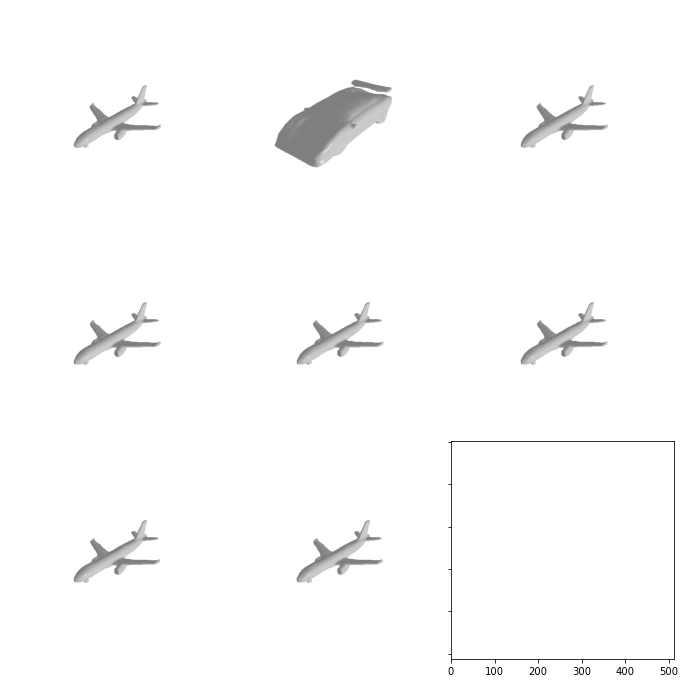

In [303]:
num_images = int(images.shape[0])
rows = 3
cols = -(- num_images // rows)

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*4,rows*4),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), range(num_images)):
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')

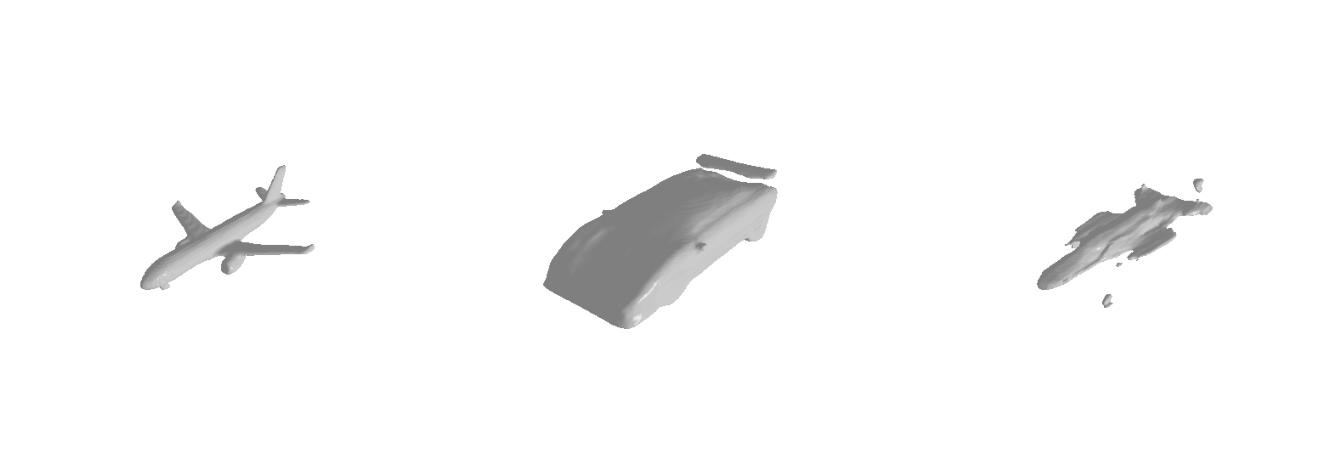

In [295]:
rows = 1
cols = 3

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*8,rows*8),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten(), [0,1,-1]):
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')

In [213]:
interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/DeepDream_300_1500/'
files = list(os.listdir(interpolation_dir))

mesh = pv.read(interpolation_dir + files[-1])
#z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=False)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [121]:
start_layer = 2
end_layer = 6
num_layer = end_layer - start_layer + 1

verts = []
faces = []
verts_rgb = []
for i in range(start_layer,1+end_layer):
    interpolation_dir = '/data/IM-NET-pytorch/data/all_vox256_img/DeepDream_300_1500_layer_{}/'.format(i)
    files = os.listdir(interpolation_dir)
    for file in files:
        vert, face = load_ply(interpolation_dir + file)
        verts.append(vert.to(device))
        faces.append(face.to(device))
        verts_rgb.append(torch.ones_like(vert).to(device))

textures = Textures(verts_rgb=verts_rgb)
interpol_mesh = Meshes(verts, faces, textures)

In [122]:
print(interpol_mesh.isempty())
print(interpol_mesh.num_verts_per_mesh())

tensor(False, device='cuda:0')
tensor([30816, 30064, 28634, 26200, 23944, 30816, 31038, 30988, 30270, 29948,
        29850, 28330, 22838, 17646, 15918, 30816, 26118, 17994, 14246, 11006,
         8438,  5756,  2540,     0,     0, 30816, 29546, 27482, 26226, 23798,
        19564, 18472, 18102, 17118, 13360, 30816, 28842, 26474, 21526, 17734,
        16446, 14960, 12970, 12082, 11066, 30816, 28444, 26020, 19246, 14836,
        11516,  9362,  6430,  3366,   296], device='cuda:0')


In [123]:
images = renderer(interpol_mesh).cpu().numpy()

In [124]:
images.shape

(55, 512, 512, 4)

9
6


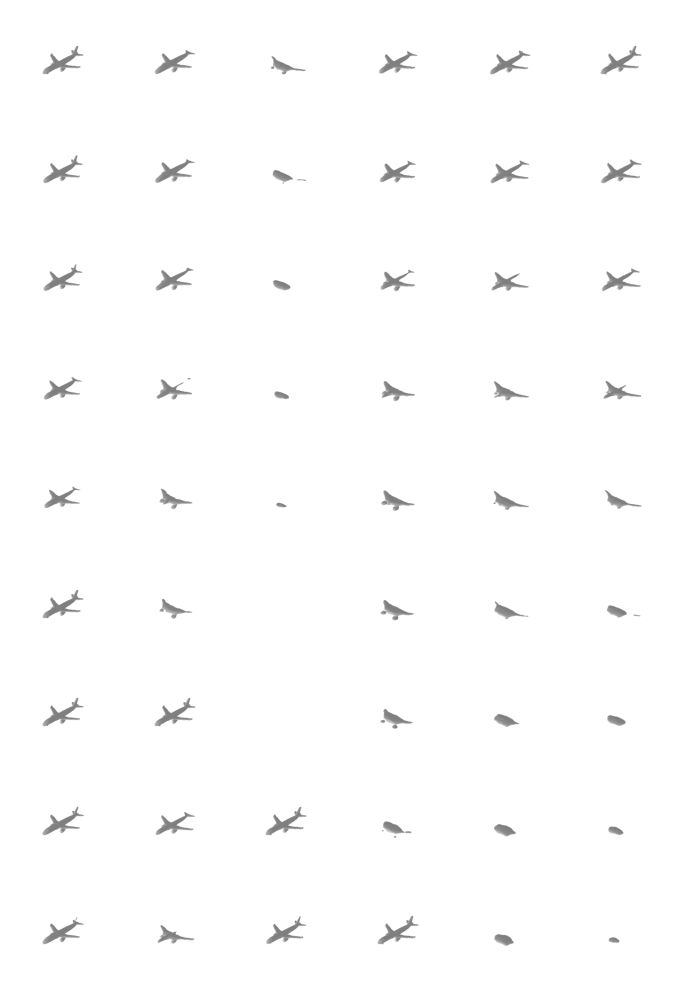

In [125]:
num_images = int(images.shape[0])
rows = int(num_images) // num_layer
print(rows)
cols = int(num_images) // rows
print(cols)

fig, axs = plt.subplots(nrows=rows, 
                        ncols=cols, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(cols*2,rows*2),
                        gridspec_kw={'wspace': 0, 'hspace':0}
                        )
for ax, im in zip(axs.flatten('F'), range(num_images)):
    ax.imshow(images[im,:,:,:3])
    ax.axis('off')